<a href="https://colab.research.google.com/github/ampnb/computervision/blob/main/ImageSegmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Just completed an amazing project that I learned from Coursera! So excited to share my newfound knowledge with all of my followers. #Coursera #LearningJourney #KnowledgeIsPower #ImageSegmentation #wanchanok #UNET

# Task 1 : Set up colab gpu runtime environment

In [94]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-mu4xxr0q
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-mu4xxr0q
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [95]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


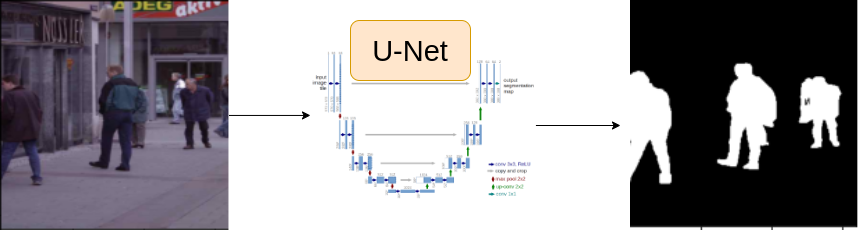

# Some Common Imports

In [96]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [97]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [98]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [99]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [100]:
row = df.iloc[5]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

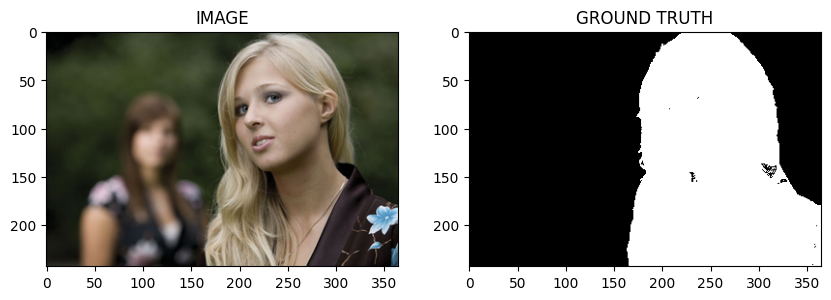

In [101]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [102]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [103]:
import albumentations as A

In [104]:
from albumentations.augmentations import HorizontalFlip
def get_train_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
  ])
def get_valid_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
  ])

# Task 4 : Create Custom Dataset 

In [105]:
from torch.utils.data import Dataset

In [131]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) --> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_train_augs())


In [132]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [133]:
for i in range(len(trainset)):
    image, mask = trainset[i]
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

Image shape: torch.Size([3, 320, 320]), Mask shape: torch.Size([1, 320, 320])


ValueError: ignored

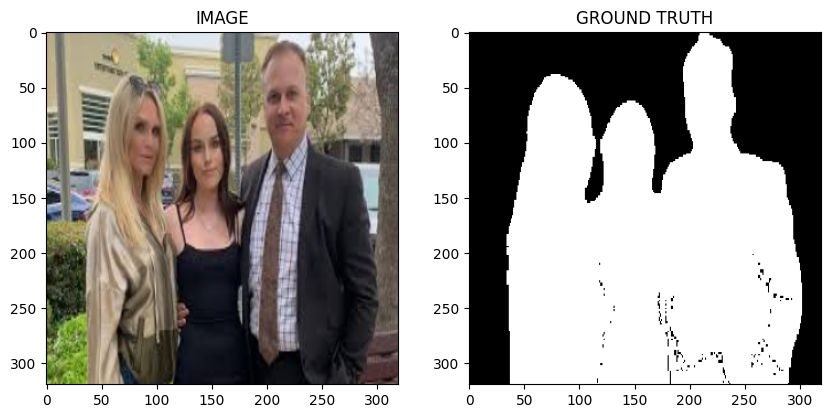

In [134]:
idx = 50
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [135]:
from torch.utils.data import DataLoader

In [136]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [137]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [138]:
for image, mask in trainloader: 
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

ValueError: ignored

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [113]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [114]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER, 
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
    def forward(self, images, masks = None):
      logits = self.arc(images)

      if masks != None:
        loss1 = DiceLoss(mode='binary')(logits, masks)
        loss2 = nn.BCEWithLogitsLoss()(logits, masks)
        return logits, loss1 + loss2

      return logits

In [115]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [116]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [117]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      loss.backward()
    

      total_loss += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [118]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [119]:
best_valid_loss = np.Inf 
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train_loss: {train_loss} Valid_loss :  {valid_loss}")

  0%|          | 0/15 [00:00<?, ?it/s]


ValueError: ignored

# Task 9 : Inference

In [120]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #C,H,W ---> 1,C,H,W
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pre_mask > 0.5) * 1.0

FileNotFoundError: ignored